In [2]:
import pandas as pd
import numpy as np
import random
from random import shuffle
random.seed(18)
import re
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
# from nltk import word_tokenize
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize,pos_tag
from textblob import TextBlob
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import stem
import csv
from sklearn.metrics import f1_score
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
pd.set_option('display.max_colwidth', None)

seed = 18


In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [4]:
# from pycorenlp import StanfordCoreNLP
# nlp = StanfordCoreNLP('http://localhost:9000')

import stanza
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline

2024-07-17 21:01:49 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-07-17 21:01:49 INFO: Downloading default packages for language: en (English) ...
2024-07-17 21:01:50 INFO: File exists: /Users/gbaldonado/stanza_resources/en/default.zip
2024-07-17 21:01:53 INFO: Finished downloading models and saved to /Users/gbaldonado/stanza_resources
2024-07-17 21:01:53 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-07-17 21:01:54 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-07-17 21:01:55 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-07-17 21:01:55 INFO: Using device: cpu
2024-07-17 21:01:55 INFO: Loading: tokenize
2024-07-17 21:01:55 INFO: Loading: mwt
2024-07-17 21:01:55 INFO: Loading: pos
2024-07-17 21:01:55 INFO: Loading: lemma
2024-07-17 21:01:55 INFO: Loading: constituency
2024-07-17 21:01:56 INFO: Loading: depparse
2024-07-17 21:01:56 INFO: Loading: sentiment
2024-07-17 21:01:56 INFO: Loading: 

In [5]:
attainment_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/single_theme_using_jaccard_method/Attainment_sentence_level_batch_1_jaccard.csv")
aspirational_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/single_theme_using_jaccard_method/Aspirational_sentence_level_batch_1_jaccard.csv")

print(attainment_df.shape, aspirational_df.shape)

(1668, 3) (3036, 3)


## Method 1: Shuffling merged, then stratify

For comparison:
### Model 1 LR with original data, no shuffling, no resampling (baseline):
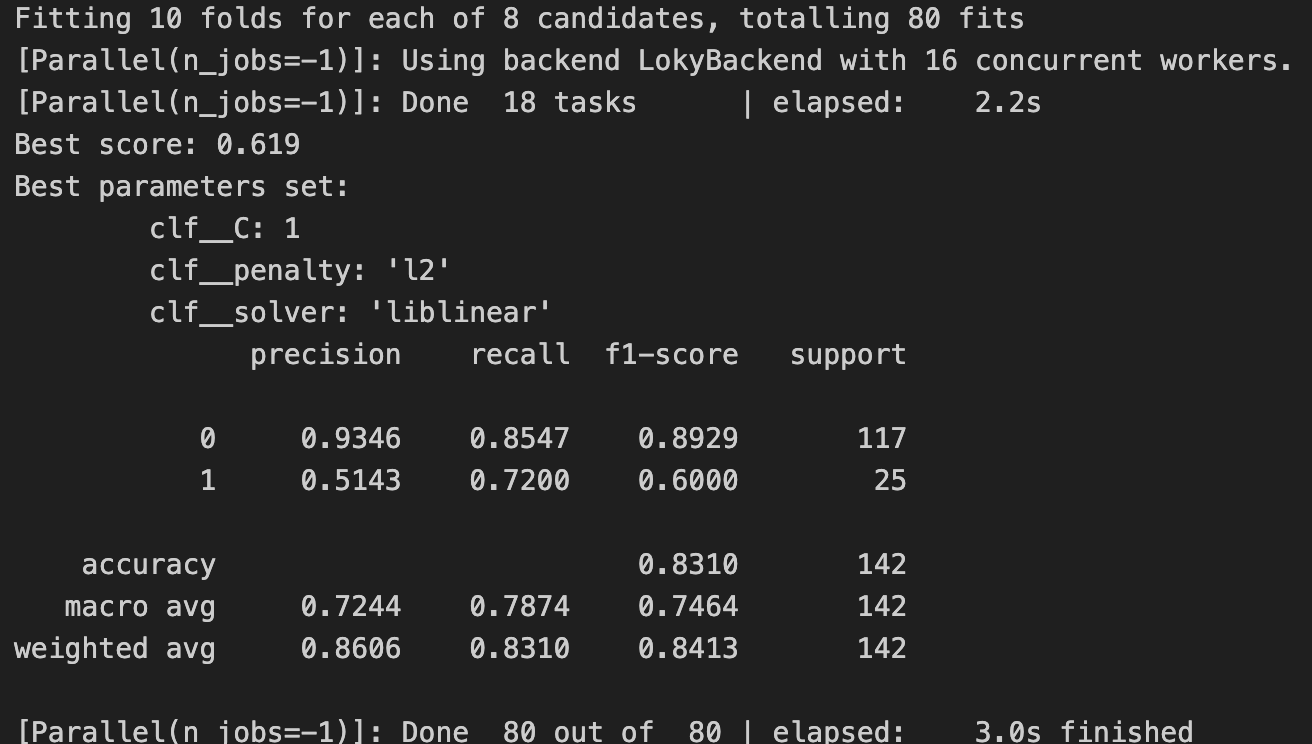

### Model 1 LR with merged data, no resampling
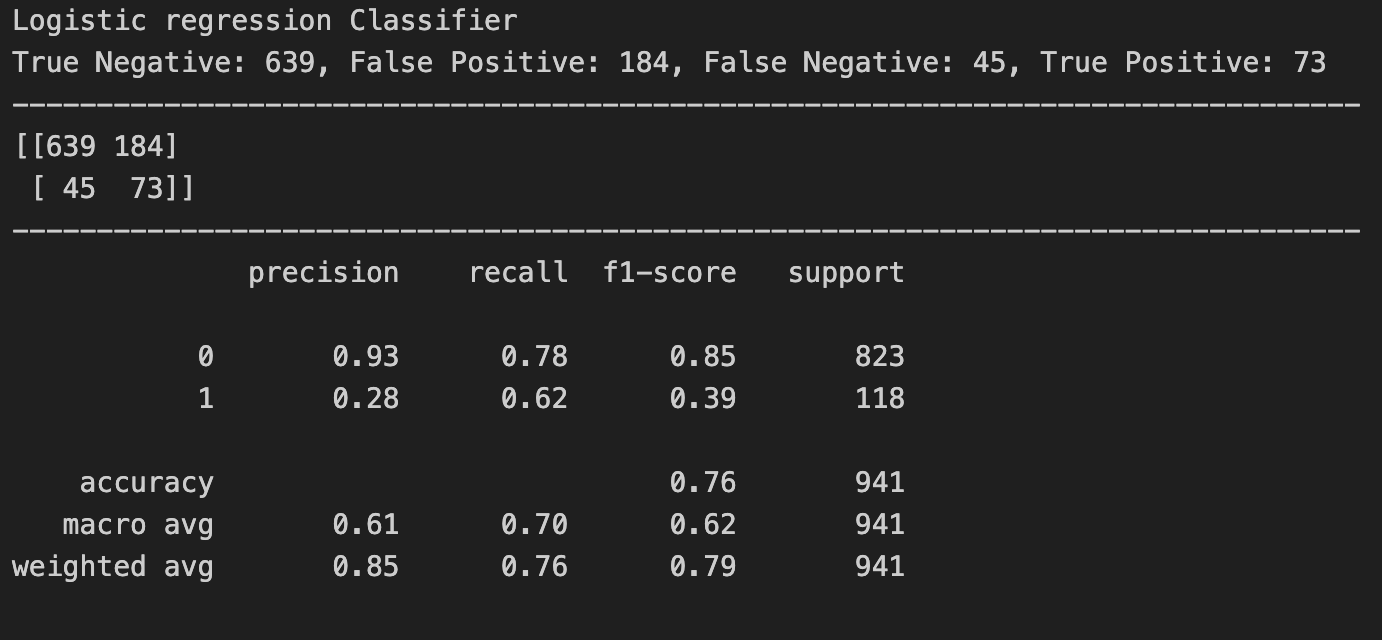


In [6]:
merged_aspirational_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Aspirational_sentence_level_batch_1_jaccard.csv", encoding='utf-8')
merged_aspirational_df = shuffle(merged_aspirational_df, random_state=seed)
training_df, test_df = train_test_split(merged_aspirational_df, test_size=0.2, random_state=seed, stratify=merged_aspirational_df['label'])
training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [7]:
merged_aspirational_df.shape

(4704, 3)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

merged_aspirational_file_path = "/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Aspirational_sentence_level_batch_1_jaccard.csv"

def balance_dataset(file_path, positive_percentage, random_state=42):
    try:
        # Load the dataset
        df = pd.read_csv(file_path, encoding='utf-8')

        # Split into training and test sets
        training_df, test_df = train_test_split(df, test_size=0.1, random_state=random_state, stratify=df['label'])
        training_df.reset_index(drop=True, inplace=True)
        test_df.reset_index(drop=True, inplace=True)

        # Separate positive and negative samples in training set
        positive_samples_train = training_df[training_df['label'] == 1]
        negative_samples_train = training_df[training_df['label'] == 0]

        # Calculate the desired number of negative samples for training set
        num_positive_train = len(positive_samples_train)
        desired_negative_count_train = int(num_positive_train / positive_percentage) - num_positive_train

        # Check if we have enough negative samples for training set
        if desired_negative_count_train > len(negative_samples_train):
            raise ValueError("Not enough negative samples to achieve the desired positive ratio in the training set.")

        # Undersample negative samples in training set
        negative_samples_undersampled_train = negative_samples_train.sample(n=desired_negative_count_train, random_state=random_state)

        # Combine the undersampled negative samples with positive samples for training set
        balanced_training_df = pd.concat([positive_samples_train, negative_samples_undersampled_train]).reset_index(drop=True)

        # Shuffle the combined DataFrame for training set
        balanced_training_df = balanced_training_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

        # Separate positive and negative samples in test set
        positive_samples_test = test_df[test_df['label'] == 1]
        negative_samples_test = test_df[test_df['label'] == 0]

        # Calculate the desired number of negative samples for test set
        num_positive_test = len(positive_samples_test)
        desired_negative_count_test = int(num_positive_test / positive_percentage) - num_positive_test

        # Check if we have enough negative samples for test set
        if desired_negative_count_test > len(negative_samples_test):
            raise ValueError("Not enough negative samples to achieve the desired positive ratio in the test set.")

        # Undersample negative samples in test set
        negative_samples_undersampled_test = negative_samples_test.sample(n=desired_negative_count_test, random_state=random_state)

        # Combine the undersampled negative samples with positive samples for test set
        balanced_test_df = pd.concat([positive_samples_test, negative_samples_undersampled_test]).reset_index(drop=True)

        # Shuffle the combined DataFrame for test set
        balanced_test_df = balanced_test_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

        print("Balanced training DataFrame:")
        print(balanced_training_df['label'].value_counts())

        print("Balanced test DataFrame:")
        print(balanced_test_df['label'].value_counts())

        return balanced_training_df, balanced_test_df

    except FileNotFoundError:
        print("Error: The file was not found. Please check the file path.")
    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage
training_df, test_df = balance_dataset(merged_aspirational_file_path, positive_percentage=0.5)
training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Balanced training DataFrame:
label
1    529
0    529
Name: count, dtype: int64
Balanced test DataFrame:
label
1    59
0    59
Name: count, dtype: int64


In [9]:
test_df

,sentence,label,phrase
0,i am here attending this school is because i want to achieve a bachelors degree.,1,['I am here attending this school is because I want to achieve a bachelors degree.']
1,i never took physics in high school i dont know what physics is going to be like but i hope i have fun and enjoy the class.,0,['I hope I have fun and enjoy the class. I like labs where is hand ons or visual so hopefully this class is like that.']
2,why i am here i am here in san francisco state because i need to get my education.,1,['I am here in San Francisco state because I need to get my education.']
3,i hope to use this skill for my current classes and see how this impacts my ability to learn and understand.,1,['I hope to use this skill for my current classes and see how this impacts my ability to learn and understand.']
4,the reason im here in this class is to help get me closer to getting my bachelors degree in computer science and hopefully work that up to a masters at least.,1,"[""The reason I'm here in this class is to help get me closer to getting my bachelor's degree in computer science and hopefully work that up to a masters at least.""]"
...,...,...,...
113,"i did okay on the first quiz, but that was because i prepared earlier.",0,['I really want to be a video gamer programmer and I know that physics is really important in that industry because of animation etc']
114,i also want to make a lot of money.,1,['I also want to make a lot of money.']
115,its pretty interesting to understand the way things work.,0,['I am here in this class to fulfill my requirements for my bachelor degree in computer science.']
116,"thus, i am here to learn physics and more to get better.",1,"['I am here to learn about physics in depth and observe the principles we learn in everyday classes and practice the logic behind the essential physics concepts.', 'I am here to understand the use of the physics and get better the apply these concepts in computer engineering', 'Thus, I am here to learn physics and more to get better.']"


In [11]:
training_df.head()

,sentence,label,phrase
0,i am here to allow myself the opportunity to succeed in something bigger than myself.,1,"['I am here in this class to get my degree, but I am here at this school to better my life.', 'I am here to allow myself the opportunity to succeed in something bigger than myself.', 'I am here in this class because I had to enroll in it but also to actually learn the material.', 'Overall I am here for my future.']"
1,im here because i need help to pass ochem. i would like help from my science community because its hard to get help and noticed when we are so many students.,1,['Im here because I need help to pass OCHEM.']
2,"hopefully, this will lead me to a career in international politics that is as fulfilling as it is impactful.",1,"['Hopefully, this will lead me to a career in international politics that is as fulfilling as it is impactful.']"
3,"getting excepted to med school means i will practice my future career and move one step closer to my dream which means i will become a heart surgeon, meaning treat people and help them so i will give back to my community.",1,"['I have a higher chance of getting excepted to med school', 'I will become a heart surgeon']"
4,"also i want to get a better grasp of concepts because when i learn one concept i understand it, but if you give me another one; i either forget about the first one or get it confused between the two.",1,['Also I want to get a better grasp of concepts']


In [12]:
pos_labels = len([n for n in training_df['label'] if n==1])
print("Positive labels present in the dataset : {}  out of {} or {}%".format(pos_labels, len(training_df['label']), (pos_labels/len(training_df['label']))*100))

Positive labels present in the dataset : 529  out of 1058 or 50.0%


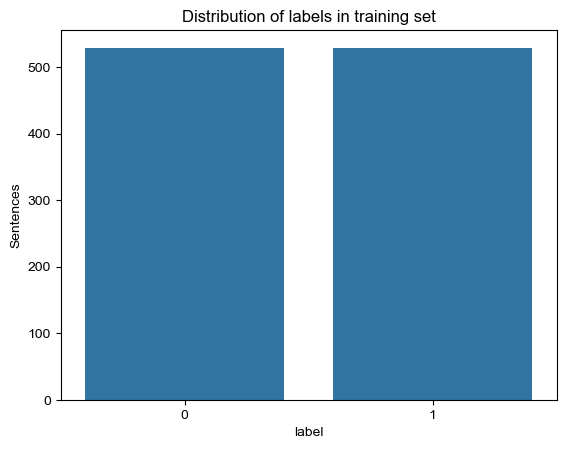

In [13]:
x = training_df['label'].value_counts()
sns.barplot(x)
sns.set(style="whitegrid")
plt.title('Distribution of labels in training set')
plt.gca().set_ylabel('Sentences')
plt.show()

In [14]:
test_df.shape

(118, 3)

In [15]:
test_df.head()

,sentence,label,phrase
0,i am here attending this school is because i want to achieve a bachelors degree.,1,['I am here attending this school is because I want to achieve a bachelors degree.']
1,i never took physics in high school i dont know what physics is going to be like but i hope i have fun and enjoy the class.,0,['I hope I have fun and enjoy the class. I like labs where is hand ons or visual so hopefully this class is like that.']
2,why i am here i am here in san francisco state because i need to get my education.,1,['I am here in San Francisco state because I need to get my education.']
3,i hope to use this skill for my current classes and see how this impacts my ability to learn and understand.,1,['I hope to use this skill for my current classes and see how this impacts my ability to learn and understand.']
4,the reason im here in this class is to help get me closer to getting my bachelors degree in computer science and hopefully work that up to a masters at least.,1,"[""The reason I'm here in this class is to help get me closer to getting my bachelor's degree in computer science and hopefully work that up to a masters at least.""]"


In [16]:
pos_labels = len([n for n in test_df['label'] if n==1])
print("Positive labels present in the test dataset : {}  out of {} or {}%".format(pos_labels, len(test_df['label']), (pos_labels/len(test_df['label']))*100))

Positive labels present in the test dataset : 59  out of 118 or 50.0%


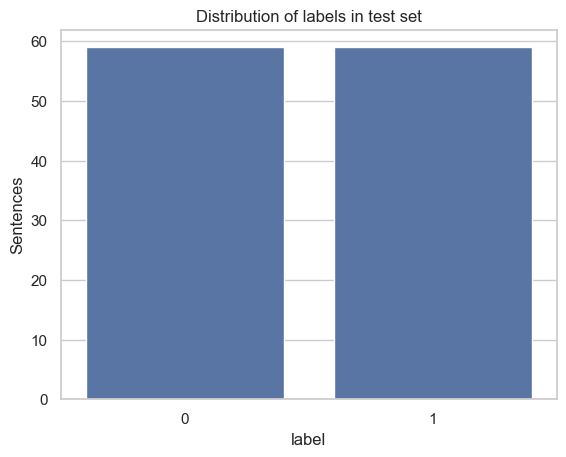

In [17]:
x1 = test_df['label'].value_counts()
sns.barplot(x1)
sns.set(style="whitegrid")
plt.title('Distribution of labels in test set')
plt.gca().set_ylabel('Sentences')
plt.show()

### FEATURE ENGINEERING

**1. NER**

In [18]:
def get_ner(text):
    ner_list = []
    # Annotate the text using stanza
    doc = nlp(text)

    for sentence in doc.sentences:
        for entity in sentence.ents:
            if entity.type == 'PERSON':
                ner_list.append(entity.text)

    return ner_list

# Example usage
text = "Barack Obama was the 44th doctor of the United States."
print(get_ner(text))

['Barack Obama']


In [19]:
# check if a named entity is present in the sentence
def named_entity_present(sentence):
    ner_list = get_ner(sentence)
    if len(ner_list) > 0:
        return 1
    else:
        return 0

**2. Similarity Features**

In [20]:
# A helper function to get the similar words and similarity score
# The function takes tokens of sentence as input and if its not a stop word, get its similarity with synsets of STEM.
stop_words = set(stopwords.words('english'))
stop_words |= set(["help","try", "work", "process", "support", "job"] )
def word_similarity(tokens, syns, field):    
    if field in ['engineering', 'technology']:
        score_threshold = 0.5
    else:
        score_threshold = 0.2
    sim_words = 0
    for token in tokens:
        if token not in stop_words:
            try:
                syns_word = wordnet.synsets(token) 
                score = syns_word[0].path_similarity(syns[0])
                if score >= score_threshold:
                    sim_words += 1
            except: 
                score = 0
    
    return sim_words

In [21]:
# Functions to create columns for similarity based on all STEM fields
syns_bio = wordnet.synsets(lemmatizer.lemmatize("biology"))
syns_maths = wordnet.synsets(lemmatizer.lemmatize("mathematics")) 
syns_tech = wordnet.synsets(lemmatizer.lemmatize("technology"))
syns_eng = wordnet.synsets(lemmatizer.lemmatize("engineering"))
syns_chem = wordnet.synsets(lemmatizer.lemmatize("chemistry"))
syns_phy = wordnet.synsets(lemmatizer.lemmatize("physics"))
syns_sci = wordnet.synsets(lemmatizer.lemmatize("science"))

**3. Medical Word Count**

In [22]:
# Load the medical specialization text file and create a list
medical_list = []
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/medical_specialities.txt', 'r') as medical_fields:
    for line in medical_fields.readlines():
        special_field = line.rstrip('\n')
        special_field = re.sub("\W"," ", special_field )
#         print(special_field)
        medical_list += special_field.split()
medical_list = list(set(medical_list))  
medical_list = [x.lower() for x in medical_list]
print(medical_list)

['endovascular', 'rheumatology', 'electrophysiology', 'interventional', 'rheumatology', 'fetal', 'disease', 'endocrinology', 'emergency', 'developmental', 'gastrointestinal', 'research', 'geriatric', 'neonatal', 'ocular', 'cytogenetics', 'disabilities', 'infectious', 'radiation', 'male', 'neurophysiology', 'internal', 'reconstructive', 'advanced', 'psychosomatic', 'sleep', 'neuroradiology', 'plastic', 'pulmonary', 'urologic', 'pediatrics', 'reproductive', 'orbit', 'care', 'preventive', 'infectious', 'infertility', 'surgical', 'endocrinology', 'physical', 'hematology', 'injury', 'neuromuscular', 'surgery', 'adolescent', 'consultation', 'dermatology', 'anesthesiology', 'ophthalmic', 'oculoplastics', 'neuropathology', 'breast', 'neurodevelopmental', 'ophthalmology', 'neuro', 'anterior', 'chemical', 'nuclear', 'ophthalmology', 'military', 'liaison', 'genitourinary', 'vascular', 'diabetes', 'anesthesiology', 'heart', 'clinical', 'palliative', 'immunopathology', 'gastroenterology', 'cornea',

In [23]:
# A helper function to get medical words
def check_medical_words(tokens):
    for token in tokens:
        if token not in stop_words and token in [x.lower() for x in medical_list]:
            return 1
        
    return 0

**4. Sentiment Polarity and Subjectivity**

In [24]:
# A helper function to get polarity and subjectivity of the sentence using TexBlob
def get_sentiment(sentence):
    sentiments =TextBlob(sentence).sentiment
    polarity = sentiments.polarity
    subjectivity = sentiments.subjectivity
    return polarity, subjectivity

**5. POS Tag Count**

In [25]:
# A helper function to get the count of POS tags of the sentence
def count_pos_tags(tokens):
    token_pos = pos_tag(tokens)
    count = Counter(tag for word,tag in token_pos)
    interjections =  count['UH']
    nouns = count['NN'] + count['NNS'] + count['NNP'] + count['NNPS']
    adverb = count['RB'] + count['RBS'] + count['RBR']
    verb = count['VB'] + count['VBD'] + count['VBG'] + count['VBN']
    determiner = count['DT']
    pronoun = count['PRP']
    adjetive = count['JJ'] + count['JJR'] + count['JJS']
    preposition = count['IN']
    return interjections, nouns, adverb, verb, determiner, pronoun, adjetive,preposition

In [26]:
def pos_tag_extraction(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

**6. Word Embeddings**

In [27]:
# Load the w2v dict from pickle file
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/pickle/embeddings06122024.pickle', 'rb') as w2v_file:
    w2v_dict = pickle.load(w2v_file)

In [28]:
print("length of word embeddings: ", len(w2v_dict.keys()))

length of word embeddings:  4762


In [29]:
# Get the vectors for the essay
def vectorizer(sequence):
    vect = []
    numw = 0
    for w in sequence: 
        try :
            if numw == 0:
                vect = w2v_dict[w]
            else:
                vect = np.add(vect, w2v_dict[w])
            numw += 1
        except Exception as e:
            pass

    return vect/ numw 

In [30]:
# Function to split text into words
def split_into_words(text):
    return text.split()

**7. Unigrams**

In [31]:
# Define the vectorizer
unigram_vect = CountVectorizer(ngram_range=(1, 1), min_df=2, stop_words = 'english')

**WRAPPER**

In [32]:
# Wrapper function for feature engineering
def feature_engineering(original_dataset):

    dataset = original_dataset.copy()
    # create a new column with sentence tokens
    dataset['tokens'] = dataset['sentence'].apply(word_tokenize)
    # 1. Similarity features
    # biology
    dataset['bio_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_bio,'biology',)) 
    # chemistry
    dataset['chem_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_chem,'chemistry',))
    # physics
    dataset['phy_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_phy,'physics',))
    # mathematics
    dataset['math_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_maths,'mathematics',))
    # technology
    dataset['tech_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_tech,'technology',))
    # engineering
    dataset['eng_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_eng,'engineering',))
    
    # medical terms
    dataset['medical_terms'] = dataset['tokens'].apply(check_medical_words)
    
    # polarity and subjectivity
    dataset['polarity'], dataset['subjectivity'] = zip(*dataset['sentence'].apply(get_sentiment))
    
    # named entity recognition
    dataset['ner'] = dataset['sentence'].apply(named_entity_present)
    
    # pos tag count
    dataset = pos_tag_extraction(dataset, 'tokens', count_pos_tags, ['interjections', 'nouns', 'adverb', 'verb', 'determiner', 'pronoun', 'adjetive','preposition'])
    
    # labels
    data_labels = dataset['label']
    # X
    data_x = dataset.drop(columns='label')

    
    # vectorize all the essays
    vect_arr = data_x.tokens.apply(vectorizer)
    for index in range(0, len(vect_arr)):
        i = 0
        for item in vect_arr[index]:
            column_name= "embedding" + str(i)
            data_x.loc[index, column_name] = item
            i +=1
    
    return data_x,data_labels
    

In [33]:
X_train, y_train = feature_engineering(training_df)

In [34]:
X_train.shape

(1058, 121)

In [35]:
y_train = y_train.astype('int')

In [36]:
X_test, y_test = feature_engineering(test_df)

In [37]:
X_test.shape

(118, 121)

In [38]:
y_test = y_test.astype('int')

In [ ]:
X_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/Aspirational/using_original/saved_feature_engineered_dataset/exp_3/X_train_final.csv", index=False)
X_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/Aspirational/using_original/saved_feature_engineered_dataset/exp_3/X_test_final.csv", index=False)
y_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/Aspirational/using_original/saved_feature_engineered_dataset/exp_3/y_train.csv", index=False)
y_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/Aspirational/using_original/saved_feature_engineered_dataset/exp_3/y_test.csv", index=False)


**Calculate Unigram features for both train and test set**

In [123]:
X_train.shape

(1058, 121)

In [124]:
X_test.shape

(118, 121)

In [125]:
# Unigrams for training set
unigram_matrix = unigram_vect.fit_transform(X_train['sentence'])
unigrams = pd.DataFrame(unigram_matrix.toarray())
print("Shape of the unigram df for train : ",unigrams.shape)
unigrams = unigrams.reset_index(drop=True)

Shape of the unigram df for train :  (1058, 915)


In [126]:
X_train_final = pd.concat([X_train, unigrams], axis = 1)

In [127]:
X_train_final.columns = X_train_final.columns.astype(str)

In [128]:
X_train_final.shape

(1058, 1036)

In [129]:
unigram_matrix_test = unigram_vect.transform(X_test['sentence'])
unigrams_test = pd.DataFrame(unigram_matrix_test.toarray())
unigrams_test = unigrams_test.reset_index(drop=True)
print("Test unigram df shape : ",unigrams_test.shape)

Test unigram df shape :  (118, 915)


In [130]:
X_test_final = pd.concat([X_test, unigrams_test], axis = 1)
X_test_final.shape

(118, 1036)

In [131]:
X_test_final.columns = X_test_final.columns.astype(str)

In [132]:
X_test_final.shape

(118, 1036)

In [133]:
for i in range(0, len(X_train_final.columns)):
    print('{} ---- {}'.format(i, X_train_final.columns[i]))

0 ---- sentence
1 ---- phrase
2 ---- tokens
3 ---- bio_sim_words
4 ---- chem_sim_words
5 ---- phy_sim_words
6 ---- math_sim_words
7 ---- tech_sim_words
8 ---- eng_sim_words
9 ---- medical_terms
10 ---- polarity
11 ---- subjectivity
12 ---- ner
13 ---- interjections
14 ---- nouns
15 ---- adverb
16 ---- verb
17 ---- determiner
18 ---- pronoun
19 ---- adjetive
20 ---- preposition
21 ---- embedding0
22 ---- embedding1
23 ---- embedding2
24 ---- embedding3
25 ---- embedding4
26 ---- embedding5
27 ---- embedding6
28 ---- embedding7
29 ---- embedding8
30 ---- embedding9
31 ---- embedding10
32 ---- embedding11
33 ---- embedding12
34 ---- embedding13
35 ---- embedding14
36 ---- embedding15
37 ---- embedding16
38 ---- embedding17
39 ---- embedding18
40 ---- embedding19
41 ---- embedding20
42 ---- embedding21
43 ---- embedding22
44 ---- embedding23
45 ---- embedding24
46 ---- embedding25
47 ---- embedding26
48 ---- embedding27
49 ---- embedding28
50 ---- embedding29
51 ---- embedding30
52 ---- em

### Model 1: Unigrams, POS Tag Count, Sentiment Polarity, Subjectivity

In [134]:
X_train_final

,sentence,phrase,tokens,bio_sim_words,chem_sim_words,phy_sim_words,math_sim_words,tech_sim_words,eng_sim_words,medical_terms,...,905,906,907,908,909,910,911,912,913,914
0,i am here to allow myself the opportunity to succeed in something bigger than myself.,"['I am here in this class to get my degree, but I am here at this school to better my life.', 'I am here to allow myself the opportunity to succeed in something bigger than myself.', 'I am here in this class because I had to enroll in it but also to actually learn the material.', 'Overall I am here for my future.']","[i, am, here, to, allow, myself, the, opportunity, to, succeed, in, something, bigger, than, myself, .]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,im here because i need help to pass ochem. i would like help from my science community because its hard to get help and noticed when we are so many students.,['Im here because I need help to pass OCHEM.'],"[im, here, because, i, need, help, to, pass, ochem, ., i, would, like, help, from, my, science, community, because, its, hard, to, get, help, and, noticed, when, we, are, so, many, students, .]",1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"hopefully, this will lead me to a career in international politics that is as fulfilling as it is impactful.","['Hopefully, this will lead me to a career in international politics that is as fulfilling as it is impactful.']","[hopefully, ,, this, will, lead, me, to, a, career, in, international, politics, that, is, as, fulfilling, as, it, is, impactful, .]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"getting excepted to med school means i will practice my future career and move one step closer to my dream which means i will become a heart surgeon, meaning treat people and help them so i will give back to my community.","['I have a higher chance of getting excepted to med school', 'I will become a heart surgeon']","[getting, excepted, to, med, school, means, i, will, practice, my, future, career, and, move, one, step, closer, to, my, dream, which, means, i, will, become, a, heart, surgeon, ,, meaning, treat, people, and, help, them, so, i, will, give, back, to, my, community, .]",0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,"also i want to get a better grasp of concepts because when i learn one concept i understand it, but if you give me another one; i either forget about the first one or get it confused between the two.",['Also I want to get a better grasp of concepts'],"[also, i, want, to, get, a, better, grasp, of, concepts, because, when, i, learn, one, concept, i, understand, it, ,, but, if, you, give, me, another, one, ;, i, either, forget, about, the, first, one, or, get, it, confused, between, the, two, .]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,"so i guess im really here because i have an interest in mechanical engineering and this class, or more specifically this laboratory, is preparing me to understand all the necessary math and physics that go into being an engineer.","['I have an interest in mechanical engineering and this class, or more specifically this laboratory, is preparing me to understand all the necessary math and physics that go into being an engineer.']","[so, i, guess, im, really, here, because, i, have, an, interest, in, mechanical, engineering, and, this, class, ,, or, more, specifically, this, laboratory, ,, is, preparing, me, to, understand, all, the, necessary, math, and, physics, that, go, into, being, an, engineer, .]",2,2,0,2,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1054,in general i am in school so that i may pursue a career in child psychiatry.,['In general I am in school so that I may pursue a career in child psychiatry.'],"[in, general, i, am, in, school, so, that, i, may, pursue, a, career, in, child, psychiatry, .]",1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1055,"more specifically, this class will get me one step closer to my career goal because this class is one of the required 

In [142]:
X_train_final.shape

(1058, 1036)

In [141]:
X_train_model_1 = X_train_final.iloc[:,np.r_[10:12,13:21,121:1036]]

In [143]:
X_train_model_1.shape

(1058, 925)

In [145]:
X_train_model_1.head(2)

,polarity,subjectivity,interjections,nouns,adverb,verb,determiner,pronoun,adjetive,preposition,...,905,906,907,908,909,910,911,912,913,914
0,0.000000,0.500000,0,3,1,2,1,2,1,2,...,0,0,0,0,0,0,0,0,0,0
1,0.104167,0.520833,0,11,2,4,0,1,1,3,...,0,0,0,0,0,0,0,0,0,0


In [147]:
X_test_model_1 = X_test_final.iloc[:,np.r_[10:12,13:21,121:1036]]

In [148]:
X_test_model_1.shape

(118, 925)

In [149]:
model_1_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_1_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_1,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_1), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.692
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.8065    0.8475    0.8264        59
           1     0.8393    0.7966    0.8174        59

    accuracy                         0.8220       118
   macro avg     0.8229    0.8220    0.8219       118
weighted avg     0.8229    0.8220    0.8219       118



In [150]:
lr_model_1 = LogisticRegression(random_state=18, 
                                solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], 
                                class_weight='balanced').fit(X_train_model_1, y_train)
y_lr = lr_model_1.predict(X_test_model_1)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 50, False Positive: 9, False Negative: 12, True Positive: 47
--------------------------------------------------------------------------------
[[50  9]
 [12 47]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        59
           1       0.84      0.80      0.82        59

    accuracy                           0.82       118
   macro avg       0.82      0.82      0.82       118
weighted avg       0.82      0.82      0.82       118



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.93 | 0.85 | 0.89 | 117 |
| Class 1 |0.51 | 0.72 | 0.60 | 25 |
| Macro Average Score | 0.72 | 0.79 | 0.75 | 142|

### Model 2: All Features

In [152]:
# X_train_model_2 = X_train_final.iloc[:,np.r_[3:1113]]
X_train_model_2 = X_train_final.iloc[:, np.r_[3:1036]]

In [153]:
X_train_model_2

,bio_sim_words,chem_sim_words,phy_sim_words,math_sim_words,tech_sim_words,eng_sim_words,medical_terms,polarity,subjectivity,ner,...,905,906,907,908,909,910,911,912,913,914
0,0,0,0,0,0,0,0,0.000000,0.500000,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,1,0.104167,0.520833,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0.000000,0.062500,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0.116667,0.511111,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,2,2,0,2,1,1,0,0.233333,0.566667,0,...,0,0,0,0,0,0,0,0,0,0
1054,1,0,0,0,0,0,1,0.050000,0.500000,0,...,0,0,0,0,0,0,0,0,0,0
1055,0,0,0,0,0,0,0,0.281250,0.500000,0,...,0,0,0,0,0,0,0,0,0,0
1056,1,0,0,0,0,0,1,0.000000,0.142857,0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
X_train_model_2.shape

(1058, 1033)

In [156]:
X_test_model_2 = X_test_final.iloc[:,np.r_[3:1036]]

In [157]:
X_test_model_2.shape

(118, 1033)

In [158]:
# from sklearn.preprocessing import StandardScaler
# # Updated pipeline with scaling
# model_2_pipeline = Pipeline([
#     # ('scaler', StandardScaler()),  # Feature scaling
#     ('clf', LogisticRegression(class_weight='balanced', random_state=18)),
# ])

# # Expanded parameter grid
# parameters = {
#     'clf__C': [0.0001, 0.001, 0.009, 0.01, 0.1, 1, 5, 10],
#     'clf__penalty': ["l2", "elasticnet"],  # Consider adding "elasticnet" if you decide to use it
#     'clf__solver': ['liblinear'],  # Include saga for larger datasets
# }

# # Using GridSearchCV with additional scoring
# grid_search = GridSearchCV(model_2_pipeline, parameters, scoring="f1", cv=10, n_jobs=-1, verbose=1)

# # Fitting the model
# grid_search.fit(X_train_model_2, y_train)

# # Best score and parameters
# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()

# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

# # Classification report on test set
# print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_2), digits=4))

model_2_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_2_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_2,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_2), digits=4))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best score: 0.716
Best parameters set:
	clf__C: 1
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.8361    0.8644    0.8500        59
           1     0.8596    0.8305    0.8448        59

    accuracy                         0.8475       118
   macro avg     0.8479    0.8475    0.8474       118
weighted avg     0.8479    0.8475    0.8474       118



In [160]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
# Fit the logistic regression model
lr_model_2 = LogisticRegression(random_state=18, 
                                 solver=best_parameters['clf__solver'], 
                                 C=best_parameters['clf__C'], 
                                 penalty=best_parameters['clf__penalty'], 
                                 class_weight='balanced').fit(X_train_model_2, y_train)

# Get predicted probabilities for the positive class
y_proba = lr_model_2.predict_proba(X_test_model_2)[:, 1]

# Set an initial threshold (0.5 is common, but can be adjusted)
threshold = 0.5
y_lr_adjusted = (y_proba >= threshold).astype(int)

# Compute confusion matrix and classification report
tn, fp, fn, tp = confusion_matrix(y_test, y_lr_adjusted).ravel()
print('Logistic Regression Classifier')
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr_adjusted))
print('-' * 80)
print(classification_report(y_test, y_lr_adjusted))

# Evaluate different thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    y_lr_temp = (y_proba >= threshold).astype(int)
    temp_precision = precision_score(y_test, y_lr_temp)
    temp_recall = recall_score(y_test, y_lr_temp)
    print(f"Threshold: {threshold:.1f}, Precision: {temp_precision:.4f}, Recall: {temp_recall:.4f}")

Logistic Regression Classifier
True Negative: 51, False Positive: 8, False Negative: 10, True Positive: 49
--------------------------------------------------------------------------------
[[51  8]
 [10 49]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        59
           1       0.86      0.83      0.84        59

    accuracy                           0.85       118
   macro avg       0.85      0.85      0.85       118
weighted avg       0.85      0.85      0.85       118

Threshold: 0.1, Precision: 0.5784, Recall: 1.0000
Threshold: 0.2, Precision: 0.6860, Recall: 1.0000
Threshold: 0.3, Precision: 0.8000, Recall: 0.9492
Threshold: 0.4, Precision: 0.8281, Recall: 0.8983
Threshold: 0.5, Precision: 0.8596, Recall: 0.8305
Threshold: 0.6, Precision: 0.9111, Recall: 0.6949
Threshold: 0.7, Precision: 0.9211, Recall: 0.5932
Threshold: 0.8, Precision: 0.9583, 

In [161]:
lr_model_2 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_2, y_train)
y_lr = lr_model_2.predict(X_test_model_2)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 51, False Positive: 8, False Negative: 10, True Positive: 49
--------------------------------------------------------------------------------
[[51  8]
 [10 49]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        59
           1       0.86      0.83      0.84        59

    accuracy                           0.85       118
   macro avg       0.85      0.85      0.85       118
weighted avg       0.85      0.85      0.85       118



In [162]:
NameOfVariables = X_train_model_2.columns.values
Var_coef = zip(lr_model_2.coef_[0,:],NameOfVariables)
sorted_coef_val = sorted(Var_coef)
for item in sorted_coef_val:
    print(item[1],'--- Value:',item[0])

407 --- Value: -1.7499431196632036
embedding87 --- Value: -1.4922865876503704
600 --- Value: -1.3573152437700782
408 --- Value: -1.3257702243935734
221 --- Value: -1.2187998195367706
embedding94 --- Value: -1.1066794842176555
515 --- Value: -1.07723411147198
660 --- Value: -1.0486382336599147
88 --- Value: -0.98500374263632
398 --- Value: -0.9180323012314104
620 --- Value: -0.9168671107330125
embedding83 --- Value: -0.8889024093742769
289 --- Value: -0.8820675075137173
124 --- Value: -0.8703525917911685
618 --- Value: -0.8537829814439711
641 --- Value: -0.8445862756163831
783 --- Value: -0.8281042469227836
101 --- Value: -0.825989450284244
486 --- Value: -0.8130318776215645
72 --- Value: -0.8115624188992481
embedding61 --- Value: -0.8050524332186685
565 --- Value: -0.8044206651686853
453 --- Value: -0.7858429732655341
837 --- Value: -0.7851048100679205
15 --- Value: -0.774655981943167
543 --- Value: -0.7742038531271024
331 --- Value: -0.7684780661766912
577 --- Value: -0.76487661769935

| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.97 | 0.88 | 0.92 | 117 |
| Class 1 |0.61 | 0.88 | 0.72 | 25 |
| Macro Average Score | 0.79 | 0.88 | 0.82 | 142|

### Model 3: Without Unigrams

In [163]:
X_train_model_3 = X_train_final.iloc[:,np.r_[3:121]]

In [164]:
X_train_model_3.shape

(1058, 118)

In [165]:
X_test_model_3 = X_test_final.iloc[:,np.r_[3:121]]

In [166]:
X_test_model_3.shape

(118, 118)

In [167]:
model_3_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.0001, 0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_3_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_3,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_3), digits=4))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.720
Best parameters set:
	clf__C: 10
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.8070    0.7797    0.7931        59
           1     0.7869    0.8136    0.8000        59

    accuracy                         0.7966       118
   macro avg     0.7970    0.7966    0.7966       118
weighted avg     0.7970    0.7966    0.7966       118



In [168]:
lr_model_3 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_3, y_train)
y_lr = lr_model_3.predict(X_test_model_3)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 46, False Positive: 13, False Negative: 11, True Positive: 48
--------------------------------------------------------------------------------
[[46 13]
 [11 48]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        59
           1       0.79      0.81      0.80        59

    accuracy                           0.80       118
   macro avg       0.80      0.80      0.80       118
weighted avg       0.80      0.80      0.80       118



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.99 | 0.82 | 0.90 | 117 |
| Class 1 |0.53 | 0.96 | 0.69 | 25 |
| Macro Average Score | 0.76 | 0.89 | 0.79 | 142|

### Model 4: Without Embeddings

In [169]:
X_train_model_4 = X_train_final.iloc[:,np.r_[3:21,121:1036]]

In [170]:
X_train_model_4.shape

(1058, 933)

In [171]:
X_test_model_4 = X_test_final.iloc[:,np.r_[3:21,121:1036]]

In [172]:
X_test_model_4.shape

(118, 933)

In [173]:
model_4_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
              'clf__C': [0.0001, 0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_4_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_4,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_4), digits=4))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.688
Best parameters set:
	clf__C: 0.001
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.5833    0.2373    0.3373        59
           1     0.5213    0.8305    0.6405        59

    accuracy                         0.5339       118
   macro avg     0.5523    0.5339    0.4889       118
weighted avg     0.5523    0.5339    0.4889       118



In [174]:
lr_model_4 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_4, y_train)
y_lr = lr_model_4.predict(X_test_model_4)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 14, False Positive: 45, False Negative: 10, True Positive: 49
--------------------------------------------------------------------------------
[[14 45]
 [10 49]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.24      0.34        59
           1       0.52      0.83      0.64        59

    accuracy                           0.53       118
   macro avg       0.55      0.53      0.49       118
weighted avg       0.55      0.53      0.49       118



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.94 | 0.89 | 0.91 | 117 |
| Class 1 |0.58 | 0.72 | 0.64 | 25 |
| Macro Average Score | 0.76 | 0.80 | 0.78 | 142|

### Model 5: Without POS Tag Count

In [176]:
X_train_model_5 = X_train_final.iloc[:,np.r_[3:13,21:1036]]

In [177]:
X_train_model_5.shape

(1058, 1025)

In [178]:
X_test_model_5 = X_test_final.iloc[:,np.r_[3:13,21:1036]]

In [179]:
X_test_model_5.shape

(118, 1025)

In [180]:
model_5_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_5_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_5,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_5), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.718
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        59
           1       0.86      0.81      0.83        59

    accuracy                           0.84       118
   macro avg       0.84      0.84      0.84       118
weighted avg       0.84      0.84      0.84       118



In [181]:
lr_model_5 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_5, y_train)
y_lr = lr_model_5.predict(X_test_model_5)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 51, False Positive: 8, False Negative: 11, True Positive: 48
--------------------------------------------------------------------------------
[[51  8]
 [11 48]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        59
           1       0.86      0.81      0.83        59

    accuracy                           0.84       118
   macro avg       0.84      0.84      0.84       118
weighted avg       0.84      0.84      0.84       118



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.96 | 0.86 | 0.91 | 117 |
| Class 1 |0.57 | 0.84 | 0.68 | 25 |
| Macro Average Score | 0.76 | 0.85 | 0.79 | 142|

In [182]:
NameOfVariables = X_train_model_5.columns.values
Var_coef = zip(lr_model_5.coef_[0,:],NameOfVariables)
sorted_coef_val = sorted(Var_coef)
for item in sorted_coef_val:
    print(item[1],'--- Value:',item[0])

embedding87 --- Value: -0.4580754944506694
407 --- Value: -0.4454735523659189
408 --- Value: -0.37111353375017053
embedding94 --- Value: -0.35724783144327654
embedding83 --- Value: -0.31154187403170125
600 --- Value: -0.26949552026214046
221 --- Value: -0.25880149660893104
embedding61 --- Value: -0.24713417757730496
88 --- Value: -0.24370550077368425
subjectivity --- Value: -0.2310065491818132
486 --- Value: -0.21518566243877232
188 --- Value: -0.2144423779973543
660 --- Value: -0.21297145127816353
507 --- Value: -0.21018022517116466
821 --- Value: -0.1971162043584473
embedding90 --- Value: -0.1946799931436207
315 --- Value: -0.1918725958675949
embedding44 --- Value: -0.1889943097444341
embedding45 --- Value: -0.18495389746779012
398 --- Value: -0.1843124397626017
268 --- Value: -0.17965658611705793
251 --- Value: -0.17896969903661614
embedding88 --- Value: -0.17854436109762437
783 --- Value: -0.17813573170016891
101 --- Value: -0.1716569885162762
embedding0 --- Value: -0.1701320905363

### Model 6: Without STEM Similarity

In [183]:
X_train_model_6 = X_train_final.iloc[:,np.r_[10:1036]]

In [184]:
X_train_model_6.shape

(1058, 1026)

In [185]:
X_test_model_6 = X_test_final.iloc[:,np.r_[10:1036]]

In [186]:
X_test_model_6.shape

(118, 1026)

In [187]:
model_6_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_6_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_6,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_6), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.717
Best parameters set:
	clf__C: 1
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        59
           1       0.88      0.83      0.85        59

    accuracy                           0.86       118
   macro avg       0.86      0.86      0.86       118
weighted avg       0.86      0.86      0.86       118



In [188]:
lr_model_6 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_6, y_train)
y_lr = lr_model_6.predict(X_test_model_6)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 52, False Positive: 7, False Negative: 10, True Positive: 49
--------------------------------------------------------------------------------
[[52  7]
 [10 49]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        59
           1       0.88      0.83      0.85        59

    accuracy                           0.86       118
   macro avg       0.86      0.86      0.86       118
weighted avg       0.86      0.86      0.86       118



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.97 | 0.87 | 0.92 | 117 |
| Class 1 |0.59 | 0.88 | 0.71 | 25 |
| Macro Average Score | 0.78 | 0.88 | 0.81 | 142|

### Model 7: Without Sentiment Features

In [190]:
X_train_model_7 = X_train_final.iloc[:,np.r_[3:10,12:1036]]

In [191]:
X_train_model_7.shape

(1058, 1031)

In [193]:
X_test_model_7 = X_test_final.iloc[:,np.r_[3:10,12:1036]]

In [194]:
X_test_model_7.shape

(118, 1031)

In [195]:
model_7_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_7_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_7,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_7), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.722
Best parameters set:
	clf__C: 1
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        59
           1       0.84      0.83      0.84        59

    accuracy                           0.84       118
   macro avg       0.84      0.84      0.84       118
weighted avg       0.84      0.84      0.84       118



In [196]:
lr_model_7 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_7, y_train)
y_lr = lr_model_7.predict(X_test_model_7)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 50, False Positive: 9, False Negative: 10, True Positive: 49
--------------------------------------------------------------------------------
[[50  9]
 [10 49]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        59
           1       0.84      0.83      0.84        59

    accuracy                           0.84       118
   macro avg       0.84      0.84      0.84       118
weighted avg       0.84      0.84      0.84       118



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.94 | 0.88 | 0.91 | 117 |
| Class 1 |0.58 | 0.76 | 0.66 | 25 |
| Macro Average Score | 0.76 | 0.82 | 0.78 | 142|

### Model 8: Without NER

In [197]:
X_train_model_8 = X_train_final.iloc[:,np.r_[3:12,13:1036]]

In [198]:
X_train_model_8.shape

(1058, 1032)

In [199]:
X_test_model_8 = X_test_final.iloc[:,np.r_[3:12,13:1036]]

In [200]:
X_test_model_8.shape

(118, 1032)

In [201]:
model_8_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_8_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_8,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_8), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.716
Best parameters set:
	clf__C: 1
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        59
           1       0.86      0.83      0.84        59

    accuracy                           0.85       118
   macro avg       0.85      0.85      0.85       118
weighted avg       0.85      0.85      0.85       118



In [202]:
lr_model_8 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_8, y_train)
y_lr = lr_model_8.predict(X_test_model_8)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 51, False Positive: 8, False Negative: 10, True Positive: 49
--------------------------------------------------------------------------------
[[51  8]
 [10 49]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        59
           1       0.86      0.83      0.84        59

    accuracy                           0.85       118
   macro avg       0.85      0.85      0.85       118
weighted avg       0.85      0.85      0.85       118



| | Precision | Recall | F1 | Data Points |
| --- | --- |--- | --- | --- |
| Class 0 | 0.96 | 0.86 | 0.91 | 117 |
| Class 1 |0.57 | 0.84 | 0.68 | 25 |
| Macro Average Score | 0.76 | 0.85 | 0.79 | 142|

### Final Summary

| S.No|Features| Precision | Recall | F1 |
| :-:| :-- | :-: |:-: | :-: |
| 1 |Embeddings + POS Tag Count + Sentiment (Polarity and Subjectivity) + STEM Similarity + NER| 0.76 | 0.89 | 0.79 |
| 2 |Unigrams + POS Tag Count + Sentiment (Polarity and Subjectivity) + STEM Similarity + NER  |0.76 | 0.80 | 0.78 |
| 3 |Embeddings + Unigrams + Sentiment (Polarity and Subjectivity) + STEM Similarity + NER | 0.76 | 0.85 | 0.79 |
| 4 |**Embeddings + Unigrams + Sentiment (Polarity and Subjectivity) + NER + POS Tag Count** | **0.78** | **0.88** | **0.81**|
| 5 |Embeddings + Unigrams + STEM Similarity + NER + POS Tag Count | 0.76 | 0.82 | 0.78|
| 6 |Embeddings + Unigrams + STEM Similarity + POS Tag Count + Sentiment (Polarity and Subjectivity) | 0.76 | 0.85 | 0.79|